##Implementing a CNN in TensorFlow

### Import Libraries and Define Globals

In [0]:
#--- Import Data
from __future__ import print_function
import argparse
import gzip
import json
import os
import pickle
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import shutil

### Common Functions

In [0]:
def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels


def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    #--- Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 28, 28, 1)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 28, 28, 1)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 28, 28, 1)
    train_y = train_y.astype('int32')
    
    print('... done loading data')
    return train_x, one_hot(train_y), valid_x, one_hot(valid_y), test_x, one_hot(test_y)


### Define the LeNet 5 Model

First, we will implement a scaled-down version of LeNet which we have discussed
during the lecture. Before you start, checkout the Tensorflow tutorial
https://www.tensorflow.org/tutorials/.
Our CNN consists of two convolutional layers (16 3 ×3 filters and a stride of
1), each followed by ReLU activation function and a max pooling layer (pool size
2). After the convolution layers we add a fully connected layer with 128 units
and a softmax layer for the classification. We train the network by optimizing
the cross-entropy loss with stochastic gradient descent.
Make sure that you save the validation performance after each epoch, i.e the
learning curve, since we are going to need them for the experiments in the next
section.

In [0]:
def LeNet_5(x, filter_size, num_filters):
 
     #---  Layer 1 Convolutional Layer
     conv1_w = tf.Variable(tf.truncated_normal(shape = [filter_size,filter_size,1,num_filters],mean = 0, stddev = 0.1)) # Filter shape filter_height * filter_width * in_channels, output_channels]
     conv1_b = tf.Variable(tf.zeros(num_filters))
     conv1 = tf.nn.conv2d(x,conv1_w, strides = [1,1,1,1], padding = 'SAME') + conv1_b 
     conv1 = tf.nn.relu(conv1)

     #--- Pooling Layer
     pool_1 = tf.nn.max_pool(conv1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

     #--- Layer 2: Convolutional. Output = 14x14xnum_filters.
     conv2_w = tf.Variable(tf.truncated_normal(shape = [filter_size,filter_size,num_filters,num_filters], mean = 0, stddev = 0.1))
     conv2_b = tf.Variable(tf.zeros(num_filters))
     conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'SAME') + conv2_b
     # TODO: Activation.
     conv2 = tf.nn.relu(conv2)

     #--- Pooling
     pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

     #--- Flatten
     fc1 = flatten(pool_2)

     #--- Layer 3 Fully Connected Layers
     flattened_size = 7*7*num_filters
     fc1_w = tf.Variable(tf.truncated_normal(shape = (flattened_size,128), mean = 0, stddev = 0.1))
     fc1_b = tf.Variable(tf.zeros(128))
     fc1 = tf.matmul(fc1,fc1_w) + fc1_b
     fc1 = tf.nn.relu(fc1)

      #--- Prepare for softmax
     fc2_w = tf.Variable(tf.truncated_normal(shape = (128,10), mean = 0, stddev = 0.1))
     fc2_b = tf.Variable(tf.zeros(10))
     fc2 = tf.matmul(fc1,fc2_w) + fc2_b
     return fc2

###Define the training and Evaluation functions

In [0]:
SAVE_PATH = './save'
MODEL_NAME = 'nmist'
tf.reset_default_graph()

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

def train_and_validate(x_train, y_train, x_valid, y_valid, num_epochs, lr, filter_size, num_filters, batch_size):
    # TODO: train and validate your convolutional neural networks with the provided data and hyperparameters
    x = tf.placeholder(tf.float32, shape=[None,28,28,1], name='input_data')
    y = tf.placeholder(tf.int32, (None), name='output_data')
    
    #create the model
    model = LeNet_5(x, filter_size, num_filters)
    
    #Softmax with cost function implementation
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits = model)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.GradientDescentOptimizer(lr)
    training_operation = optimizer.minimize(loss_operation)
    
    #Train the model
    correct_prediction = tf.equal(tf.argmax(model,1), tf.argmax(y,1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    
    #Register The learning curve
    learning_curve = np.zeros(num_epochs)
    
    #Save model 
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
          sess.run(tf.global_variables_initializer())
          num_examples = len(x_train)
          print("Training... with dataset - X:{} and Y:{} ".format(x_train.shape, y_train.shape))
          print()
          for i in range(num_epochs):
              x_train_shuffled, y_train_shuffled = shuffle(x_train, y_train)
              for offset in range(0, num_examples, batch_size):
                  end = offset + batch_size
                  batch_x, batch_y = x_train_shuffled[offset:end], y_train_shuffled[offset:end]          
                  sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
              learning_curve[i] =  1 - accuracy_operation.eval({x: x_valid, y: y_valid})
          path = saver.save(sess, SAVE_PATH + "/model.ckpt")
          print("saved at {}".format(path))
          print('-'*40, "\nValidation Error = {:.3f}\n".format(learning_curve[-1]), '-'*40) 
    return learning_curve, path  # TODO: Return the validation error after each epoch (i.e learning curve) and your model


def test(x_test, y_test, model):
    tf.reset_default_graph()
    graph = tf.Graph()
    with tf.Session(graph=graph) as sess:
        # import the saved graph
        saver = tf.train.import_meta_graph(model + ".meta")
        saver.restore(sess, model)
        # get the tensors that we need
        _x = graph.get_tensor_by_name('input_data:0')
        _y = graph.get_tensor_by_name('output_data:0')
        _accuracy = graph.get_tensor_by_name('accuracy:0')
        test_error = 1 - _accuracy.eval({_x: x_test, _y: y_test})
        
    return test_error

### The main code 

In [5]:
#--- Define global settings for the run
lr = 0.1
filter_size = 3
num_filters = 16
batch_size = 128
epochs = 5

#---  train and test convolutional neural network
x_train, y_train, x_valid, y_valid, x_test, y_test = mnist()
learning_curve, model = train_and_validate(x_train, y_train, x_valid, y_valid, epochs, lr, filter_size, num_filters, batch_size)
test_error = test(x_test, y_test, model)
print("The test Error here is {}...".format(test_error))
#--- save results in a dictionary and write them into a .json file
results = dict()
results["lr"] = lr
results["num_filters"] = num_filters
results["batch_size"] = batch_size
results["learning_curve"] = learning_curve.tolist()
results["test_error"] = test_error

path = "results"
os.makedirs(path, exist_ok=True)
fname = os.path.join(path, "results_run_%d.json" % 1)

fh = open(fname, "w")
json.dump(results, fh)
fh.close()

... loading data
... done loading data
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.016
 ----------------------------------------
INFO:tensorflow:Restoring parameters from ./save/model.ckpt
The test Error here is 0.016499996185302734...


## Learning Rate
After implementing our neural network and making sure that it works correctly,
we will have a look on the effect of the learning rate on the network’s perfor-
mance. Try the following values for the learning rate: {0.1, 0.01, 0.001, 0.0001},
save the results (validation performance after each epoch) and plot all learning
curves in the same figure.

... loading data
... done loading data
---------------------------------------- 
Working on LR=0.1
 ----------------------------------------
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.013
 ----------------------------------------
INFO:tensorflow:Restoring parameters from ./save/model.ckpt
---------------------------------------- 
Working on LR=0.01
 ----------------------------------------
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.024
 ----------------------------------------
INFO:tensorflow:Restoring parameters from ./save/model.ckpt
---------------------------------------- 
Working on LR=0.001
 ----------------------------------------
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
-----------------------------

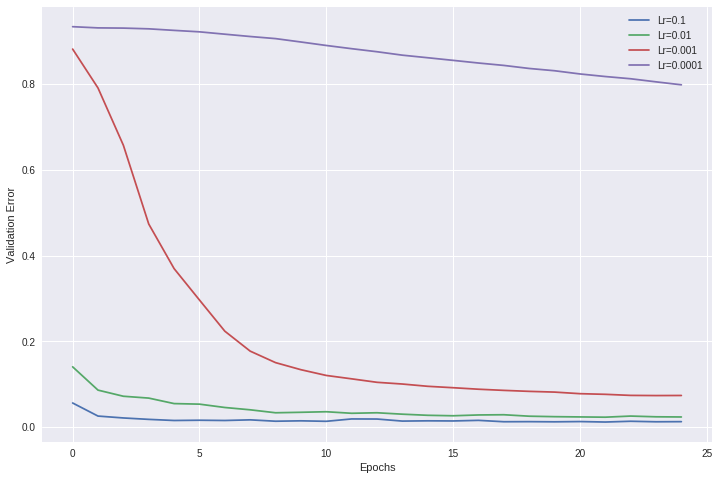

In [6]:
#--- Read the common definitions
x_train, y_train, x_valid, y_valid, x_test, y_test = mnist()
filter_size = 3
num_filters = 16
lr = [0.1, 0.01, 0.001, 0.0001]
batch_size = 128
epochs = 25

#--- save results in a dictionary and write them into a .json file
results = [dict() for x in range(len(lr))]

#--- Figure to plot
plt.figure(figsize=(12, 8))
                                                               
for i in range(len(lr)):

    print('-' * 40, "\nWorking on LR={}\n".format(lr[i]), '-' * 40)

  
    #--- Make sure to start clean
    tf.reset_default_graph()
    learning_curve, model = train_and_validate(x_train, y_train, x_valid, y_valid, epochs, lr[i], filter_size, num_filters, batch_size)
    
    test_error = test(x_test, y_test, model)
    results[i]["lr"] = lr
    results[i]["num_filters"] = num_filters
    results[i]["filter_size"] = filter_size
    results[i]["batch_size"] = batch_size
    results[i]["learning_curve"] = learning_curve.tolist()
    results[i]["test_error"] = test_error
    plt.plot(learning_curve, label="Lr=" + str(lr[i]))

    #--- Store the information
    fname = os.path.join(path, "results_run_lr_" + str(lr[i]) + ".json")
    fh = open(fname, "w")
    json.dump(results[i], fh)
    fh.close()
                                 
                                 
#--- Some final details for the plot
plt.ylabel('Validation Error')                                 
plt.xlabel('Epochs')                                 
plt.legend(loc='best')                             


Which conclusions could be drawn from this figure? Which value for the
learning rate works best? Do you have an idea what is happening if the learning
rate is too small / high?

##Convolution Type
In the lecture we learned that one can use different filter size for the convolutions.
Try out the following filter sizes {1, 3, 5, 7} (the same for height and width) and
report the results. Make sure that for all filter sizes you use the padding strategy
’SAME’.

... loading data
... done loading data
---------------------------------------- 
Working on filter_size=1
 ---------------------------------------- 

Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.046
 ----------------------------------------
INFO:tensorflow:Restoring parameters from ./save/model.ckpt
---------------------------------------- 
Working on filter_size=3
 ---------------------------------------- 

Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.015
 ----------------------------------------
INFO:tensorflow:Restoring parameters from ./save/model.ckpt
---------------------------------------- 
Working on filter_size=5
 ---------------------------------------- 

Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
-----

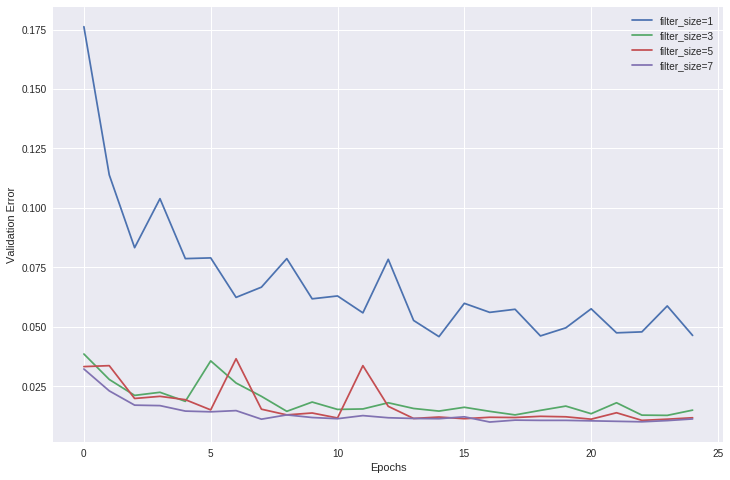

In [7]:
#--- Read the common definitions
x_train, y_train, x_valid, y_valid, x_test, y_test = mnist()
filter_size = [1, 3, 5, 7]
num_filters = 16
lr = 0.1
batch_size = 128
epochs = 25

#--- save results in a dictionary and write them into a .json file
results = [dict() for x in range(len(filter_size))]

#--- Figure to plot
plt.figure(figsize=(12, 8))
                                                               
for i in range(len(filter_size)):

    print('-' * 40, "\nWorking on filter_size={}\n".format(filter_size[i]), '-' * 40, "\n")

  
    #--- Make sure to start clean
    tf.reset_default_graph()
    learning_curve, model = train_and_validate(x_train, y_train, x_valid, y_valid, epochs, lr, filter_size[i], num_filters, batch_size)
    
    test_error = test(x_test, y_test, model)
    results[i]["lr"] = lr
    results[i]["filter_size"] = filter_size[i]
    results[i]["num_filters"] = num_filters
    results[i]["batch_size"] = batch_size
    results[i]["learning_curve"] = learning_curve.tolist()
    results[i]["test_error"] = test_error
    plt.plot(learning_curve, label="filter_size=" + str(filter_size[i]))

    # Store the information
    fname = os.path.join(path, "results_run_filter_size_" + str(filter_size[i]) + ".json")
    fh = open(fname, "w")
    json.dump(results[i], fh)
    fh.close()
                                 
                                 
# Some final details for the plot
plt.ylabel('Validation Error')                                 
plt.xlabel('Epochs')                                 
plt.legend(loc='best')   

Again plot the learning curves and analyze the results. Do you have an idea
in which scenarios smaller filters might be better than larger filters and vice
versa?

##Random Search
As you can see, setting the hyperparameters correctly makes a huge differ-
ence. Unfortunately, the most hyperparameter are not easily transferable across
datasets, for instance the optimal learning rate depends on the dataset. Besides
the learning rate and the filter sizes, there are more hyperparameters that can
be tuned. In the last part of this exercise we will apply random search to
automatically tune the following hyperparameters:
* learning rate ∈ [10 −4 , 10 −1 ]
* batch size ∈ [16, 128]
* number of filters ∈ [2^3 , 2^6 ]
* filter size ∈ {3, 5}


Make sure that you optimize the first three on a logarithmic scale and that
the filter size is a categorical hyperparameter. Run random search for 50 iter-
ations where each function evaluation has a budget of 6 epochs. We will use
the HpBandster (https://github.com/automl/HpBandSter) package for random
search. You can install via ’pip install hpbandster’ .

In order to evaluate the progress of random search, plot the validation per-
formance of the best found configuration after each iteration. Finally, evaluate
the test performance of the best configuration that you found.

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


... loading data
... done loading data
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.018
 ----------------------------------------
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.020
 ----------------------------------------
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.011
 ----------------------------------------
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.024
 ----------------------------------------
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validati

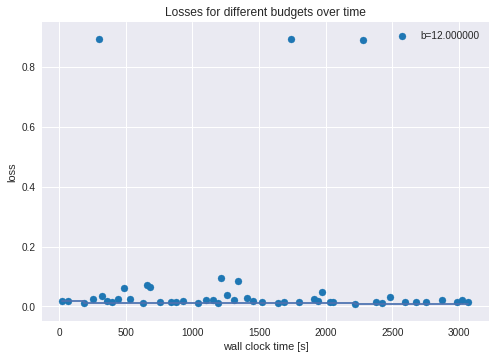

In [8]:
!pip install hpbandster
import logging

logging.basicConfig(level=logging.WARNING)

import hpbandster.core.nameserver as hpns

from hpbandster.optimizers import RandomSearch

import ConfigSpace as CS
from hpbandster.core.worker import Worker
import argparse


class MyWorker(Worker):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.x_train, self.y_train, self.x_valid, self.y_valid, self.x_test, self.y_test = mnist("./")

    def compute(self, config, budget, **kwargs):
        """
        Evaluates the configuration on the defined budget and returns the validation performance.
        Args:
            config: dictionary containing the sampled configurations by the optimizer
            budget: (float) amount of time/epochs/etc. the model can use to train
        Returns:
            dictionary with mandatory fields:
                'loss' (scalar)
                'info' (dict)
        """

        learning_curve, model = train_and_validate(self.x_train, self.y_train, self.x_valid, self.y_valid, int(budget), config['lr'], int(config['filter_size']), int(config['num_filters']), int(config['batch_size']))
    
        validation_error = learning_curve[-1]
        
        # TODO: We minimize so make sure you return the validation error here
        return ({
            'loss': validation_error,  # this is the a mandatory field to run hyperband
            'info': {}  # can be used for any user-defined information - also mandatory
        })

    @staticmethod
    def get_configspace():
        config_space = CS.ConfigurationSpace()

        lr = CS.hyperparameters.UniformFloatHyperparameter('lr', lower=10e-4, upper=10e-1, default_value=1e-2, log=True)

        batch_size = CS.hyperparameters.UniformIntegerHyperparameter('batch_size', lower=16, upper=128, default_value=64, log=True)
        
        num_filters = CS.hyperparameters.UniformIntegerHyperparameter('num_filters', lower=8, upper=64, default_value=16, log=True)
        # For demonstration purposes, we add different optimizers as categorical hyperparameters.
        # To show how to use conditional hyperparameters with ConfigSpace, we'll add the optimizers 'Adam' and 'SGD'.
        # SGD has a different parameter 'momentum'.
        filter_size = CS.hyperparameters.CategoricalHyperparameter('filter_size', ['3', '5'])
  
        config_space.add_hyperparameters([lr, batch_size, num_filters, filter_size])

        # TODO: Implement configuration space here. See https://github.com/automl/HpBandSter/blob/master/hpbandster/examples/example_5_keras_worker.py  for an example
        
        return config_space


#parser = argparse.ArgumentParser(description='Example 1 - sequential and local execution.')
#parser.add_argument('--budget', type=float,
#                    help='Maximum budget used during the optimization, i.e the number of epochs.', default=12)
#parser.add_argument('--n_iterations', type=int, help='Number of iterations performed by the optimizer', default=20)
#args = parser.parse_args()

# Step 1: Start a nameserver
# Every run needs a nameserver. It could be a 'static' server with a
# permanent address, but here it will be started for the local machine with the default port.
# The nameserver manages the concurrent running workers across all possible threads or clusternodes.
# Note the run_id argument. This uniquely identifies a run of any HpBandSter optimizer.
NS = hpns.NameServer(run_id='example1', host='127.0.0.1', port=None)
NS.start()

# Step 2: Start a worker
# Now we can instantiate a worker, providing the mandatory information
# Besides the sleep_interval, we need to define the nameserver information and
# the same run_id as above. After that, we can start the worker in the background,
# where it will wait for incoming configurations to evaluate.
w = MyWorker(nameserver='127.0.0.1', run_id='example1')
w.run(background=True)

# Step 3: Run an optimizer
# Now we can create an optimizer object and start the run.
# Here, we run RandomSearch, but that is not essential.
# The run method will return the `Result` that contains all runs performed.

rs = RandomSearch(configspace=w.get_configspace(),
                  run_id='example1', nameserver='127.0.0.1',
                  min_budget=int(12), max_budget=int(12))
#                  min_budget=int(args.budget), max_budget=int(args.budget))
#res = rs.run(n_iterations=args.n_iterations)
res = rs.run(n_iterations=50)

# Step 4: Shutdown
# After the optimizer run, we must shutdown the master and the nameserver.
rs.shutdown(shutdown_workers=True)
NS.shutdown()

# Step 5: Analysis
# Each optimizer returns a hpbandster.core.result.Result object.
# It holds information about the optimization run like the incumbent (=best) configuration.
# For further details about the Result object, see its documentation.
# Here we simply print out the best config and some statistics about the performed runs.
id2config = res.get_id2config_mapping()
incumbent = res.get_incumbent_id()

print('Best found configuration:', id2config[incumbent]['config'])


# Plots the performance of the best found validation error over time
all_runs = res.get_all_runs()
# Let's plot the observed losses grouped by budget,
import hpbandster.visualization as hpvis

hpvis.losses_over_time(all_runs)

import matplotlib.pyplot as plt
plt.savefig("random_search.png")

# TODO: retrain the best configuration (called incumbent) and compute the test error

... loading data
... done loading data
Training... with dataset - X:(50000, 28, 28, 1) and Y:(50000, 10) 

saved at ./save/model.ckpt
---------------------------------------- 
Validation Error = 0.011
 ----------------------------------------
INFO:tensorflow:Restoring parameters from ./save/model.ckpt


INFO:tensorflow:Restoring parameters from ./save/model.ckpt


Test Error is 0.0098000168800354


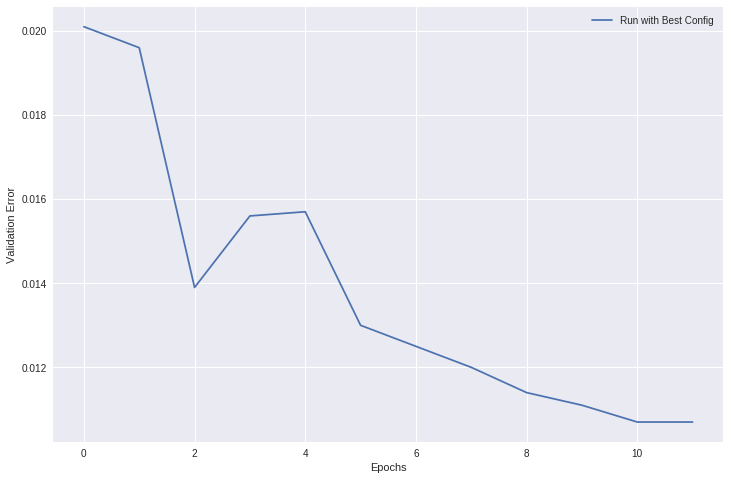

In [9]:
#--- Retrain on the best config
lr = id2config[incumbent]['config']['lr']
filter_size = int(id2config[incumbent]['config']['filter_size'])
num_filters = int(id2config[incumbent]['config']['num_filters'])
batch_size = int(id2config[incumbent]['config']['batch_size'])
epochs = 12

#---  train and test convolutional neural network
x_train, y_train, x_valid, y_valid, x_test, y_test = mnist()
learning_curve, model = train_and_validate(x_train, y_train, x_valid, y_valid, epochs, lr, filter_size, num_filters, batch_size)
test_error = test(x_test, y_test, model)
print("Test Error is {}".format(test_error))

#--- Plot
plt.figure(figsize=(12, 8))
plt.plot(learning_curve, label="Run with Best Config")
plt.ylabel('Validation Error')                                 
plt.xlabel('Epochs')                                 
plt.legend(loc='best') 